# The Battle of Neighborhoods

## INTRODUCTION
#### New York City's demographics show that it is a large and ethnically diverse metropolis. With its diverse culture, comes diverse food items. There are many restaurants in New York City, each belonging to different categories like Chinese, Indian, and French etc.

## DATA Required
#### 1. New York City data that contains list Boroughs, Neighbourhoods along with their latitude and longitude.
#### 2. Indian restaurants in each neighbourhood of New York City.
#### 3. GeoSpace data

## Questions to be answered.
#### 1. Best Place to have Indian Cuisine in NY based on rating, likes and tips.
#### 2. Place with potential of opening Indian Restaurant Market.
#### 3. Place which lacks Indian restaurants.
#### 4. Place to stay if you like indian cuisine

## METHODOLOGY
#### 1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
#### 2. We will find all venues for each neighborhood using FourSquare API.
#### 3. We will then filter out all Indian Restuarant venues.
#### 4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Indian Resturants.
#### 5. Next we will sort the data keeping Ratings as the constraint.
#### 6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py36h9f0ad1d_0         152 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         395 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  ca-certificates                     2020.4.5

#### Function to get latitude and longitude values of a given address

In [3]:
def get_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

#### First, let's get the new york data with it's neighborhoods latitude and longitude

In [4]:
#def get_ny_data():
url='https://cocl.us/new_york_dataset'
resp=requests.get(url).json()
ny_data=resp['features']
columns_name=['Borough','Neighborhood','Latitude','Longitude']
new_york_data=pd.DataFrame(columns=columns_name)
for data in ny_data: 
    borough=data['properties']['borough']
    neigh=data['properties']['name']
    
    latitude=data['geometry']['coordinates'][1]
    long=data['geometry']['coordinates'][0]

    new_york_data= new_york_data.append({'Borough':borough,
                         'Neighborhood':neigh,
                         'Latitude':latitude,
                         'Longitude':long}, ignore_index=True)

In [5]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
new_york_data.shape

(306, 4)

#### Define your Foresquare credentials

In [8]:
CLIENT_ID='WH5U2MTTP0RK4QEVXHHS1KF2WLX1XBZ32E02RUGJS0JCZFRL'
CLIENT_SECRET='YPZKKYZCUSY3VNXS3EJTD2N3N4FPH0POPGUXPV1CD1H15U2G'
VERSION= '20200613'

#### Function to see venues in each neighborhood

In [9]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
lat=new_york_data.loc[139,'Latitude']
lng=new_york_data.loc[139,'Longitude']
trial=get_venues(lat,lng).head()

#### Function to see venue details

In [11]:
def get_venue_details(venue_id):
    
    url='https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}&'.format(
            venue_id,  
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    detail_data=requests.get(url).json()
    venue_data=detail_data['response']['venue']
    column_names=['ID','Name','Likes','Rating','Tips']
    venue_detail=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_detail.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    venue_df=pd.DataFrame(venue_detail,columns=column_names)
    return venue_df

In [12]:
id=trial.loc[0,'ID']
print(id)
get_venue_details(id)

49ff6b95f964a5201f701fe3


,ID,Name,Likes,Rating,Tips
0,49ff6b95f964a5201f701fe3,Dutch Kills,733,9.2,257


#### Let's see a bar graph for the number of neighborhoods in each Borough

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

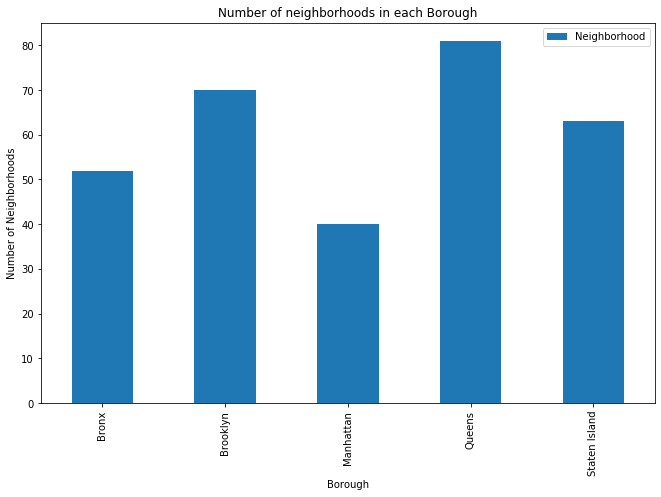

In [16]:
plt.figure(figsize=(11,7))
plt.title('Number of neighborhoods in each Borough')
plt.xlabel('Boroughs')
plt.ylabel('Number of Neighborhoods')
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

### This shows that Queens Borough has the maximum number of neighborhoods
#### Let's find the Indian Restraurants in neighborhoods.

In [20]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

In [21]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [22]:
indian_rest_ny.shape

(144, 4)

#### By this we can see there are 144 Indian restaurants in New York Neighborhoods

#### Now, lets see the number of Indian Restaurants in each neighborhoods

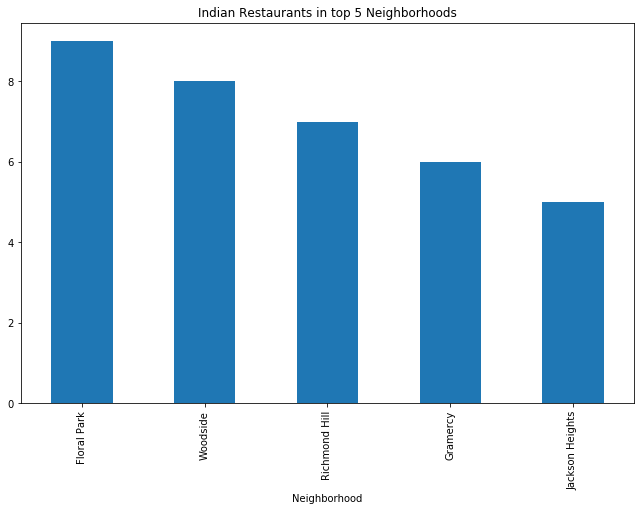

In [24]:
plt.figure(figsize=(11,7))
plt.title('Indian Restaurants in top 5 Neighborhoods')
plt.xlabel('Neighborhoods')
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.show()

In [25]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
101,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
102,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
103,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
104,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
105,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
106,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
107,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
108,Queens,Floral Park,55d68c1b498ecf05fa196fe1,Namaste Restaurant and Cafe
109,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


#### This shows Floral Park in Queens have maximum Indian Restaurants

### Now let us see the ranking of Indian restaurants.

In [26]:
colummn_names=['Borough','Neighborhood','ID','Name','Likes','Rating','Tips']
indian_rest_ny_stat=pd.DataFrame(columns=column_names)
count=1
for Borough,Neighborhood,ID,Name in indian_rest_ny.values.tolist():
    try:
        rating_rest=get_venue_details(ID)
        id,name,likes,rating,tips= rating_rest.values.tolist()[0]
    except IndexError:
        print('No data present for this ID: ', ID)
    print('(',count,'/', len(indian_rest_ny),')', ' is processed')
    indian_rest_ny_stat=indian_rest_ny_stat.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood,
                                                'ID': id,
                                                'Name': Name,
                                                'Likes': likes,
                                                'Rating':rating,
                                                'Tips':tips},ignore_index=True)
    count=count+1

( 1 / 144 )  is processed
( 2 / 144 )  is processed
( 3 / 144 )  is processed
( 4 / 144 )  is processed
( 5 / 144 )  is processed
( 6 / 144 )  is processed
( 7 / 144 )  is processed
( 8 / 144 )  is processed
( 9 / 144 )  is processed
( 10 / 144 )  is processed
( 11 / 144 )  is processed
( 12 / 144 )  is processed
( 13 / 144 )  is processed
( 14 / 144 )  is processed
( 15 / 144 )  is processed
( 16 / 144 )  is processed
( 17 / 144 )  is processed
( 18 / 144 )  is processed
( 19 / 144 )  is processed
( 20 / 144 )  is processed
( 21 / 144 )  is processed
( 22 / 144 )  is processed
( 23 / 144 )  is processed
( 24 / 144 )  is processed
( 25 / 144 )  is processed
( 26 / 144 )  is processed
( 27 / 144 )  is processed
( 28 / 144 )  is processed
( 29 / 144 )  is processed
( 30 / 144 )  is processed
( 31 / 144 )  is processed
( 32 / 144 )  is processed
( 33 / 144 )  is processed
( 34 / 144 )  is processed
( 35 / 144 )  is processed
( 36 / 144 )  is processed
( 37 / 144 )  is processed
( 38 / 144

In [27]:
indian_rest_ny_stat.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5.0,7.8,10.0
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3.0,6.0,2.0
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13.0,6.0,9.0
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8.0,6.8,3.0
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3.0,6.0,2.0


In [28]:
indian_rest_ny_stat.shape

(144, 7)

##### Let's save this as csv file as it will be premium call and we have to limit it till 500

In [29]:
indian_rest_ny_stat.to_csv('Indian Restaurant NY Statistcs.csv',index=False)

###### Check the saved file.

In [30]:
indian_rest_stat_csv=pd.read_csv('Indian Restaurant NY Statistcs.csv')

In [31]:
NY_df=indian_rest_stat_csv

In [32]:
NY_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       144 non-null    object 
 1   Neighborhood  144 non-null    object 
 2   ID            144 non-null    object 
 3   Name          144 non-null    object 
 4   Likes         144 non-null    float64
 5   Rating        144 non-null    float64
 6   Tips          144 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.0+ KB


###### Rating, Likes and Tips are in float. Thus we can perform further operations.

#### Info about the Indian restaurant with maximum likes

In [34]:
NY_df[NY_df.Likes==NY_df.Likes.max()]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
42,Manhattan,Tribeca,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,590.0,8.6,148.0
124,Manhattan,Civic Center,4bbb9dbded7776b0e1ad3e51,Tamarind TriBeCa,590.0,8.6,148.0
125,Staten Island,Concord,4bbb9dbded7776b0e1ad3e51,Al-Humza,590.0,8.6,148.0
126,Staten Island,Emerson Hill,4bbb9dbded7776b0e1ad3e51,Al-Humza,590.0,8.6,148.0


##### Restaurant with maximum rating

In [35]:
NY_df[NY_df.Rating==NY_df.Rating.max()]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
54,Queens,Astoria,4aa56c81f964a5204e4820e3,Seva Indian Cuisine,239.0,9.0,133.0
81,Queens,Long Island City,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0
83,Queens,Sunnyside,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0
138,Queens,Blissville,5b931ea69d7468002c3b1382,Adda,129.0,9.0,35.0


#### Restaurant with maximum tips

In [36]:
NY_df[NY_df.Tips==NY_df.Tips.max()]

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
51,Manhattan,Gramercy,4a12eb1ff964a52099771fe3,Dhaba,497.0,8.3,164.0


#### Let us see Neighborhoods with maximum average rating

In [60]:
neigh_max_rating=NY_df.groupby('Neighborhood',as_index=False).mean()
avg_neigh_rating=neigh_max_rating[['Neighborhood','Rating']]
avg_neigh_rating.sort_values(['Rating'],ascending=False).head(10)

,Neighborhood,Rating
0,Astoria,9.0
5,Blissville,9.0
25,Fort Greene,8.8
49,Prospect Heights,8.7
12,Civic Center,8.6
71,West Village,8.6
66,Tribeca,8.6
21,Emerson Hill,8.6
31,Greenwich Village,8.6
14,Concord,8.6


In [122]:
avg_neigh_rating.sort_values(['Rating'],ascending=True).head(10)

,Neighborhood,Rating
48,Parkchester,6.000000
60,Spuyten Duyvil,6.000000
68,Unionport,6.000000
55,Richmond Hill,6.614286
28,Glen Oaks,6.625000
16,Concourse Village,6.800000
15,Concourse,6.800000
24,Floral Park,6.877778
47,Park Hill,6.900000
22,Erasmus,6.900000


In [123]:
new_york_data[new_york_data['Neighborhood']=='Parkchester']

,Borough,Neighborhood,Latitude,Longitude
30,Bronx,Parkchester,40.837938,-73.856003


#### Thus, Parkchester in Bronx borough have lowest rating.

#### Similarly, Let's see maximum average rating for Borough

In [64]:
Borough_max_rating=NY_df.groupby('Borough',as_index=False).mean()
avg_Borough_rating=Borough_max_rating[['Borough','Rating']]
avg_Borough_rating.sort_values(['Rating'],ascending=False).head()

,Borough,Rating
2,Manhattan,8.139394
4,Staten Island,7.866667
1,Brooklyn,7.707407
3,Queens,7.531884
0,Bronx,6.566667


#### Let's visualise it.

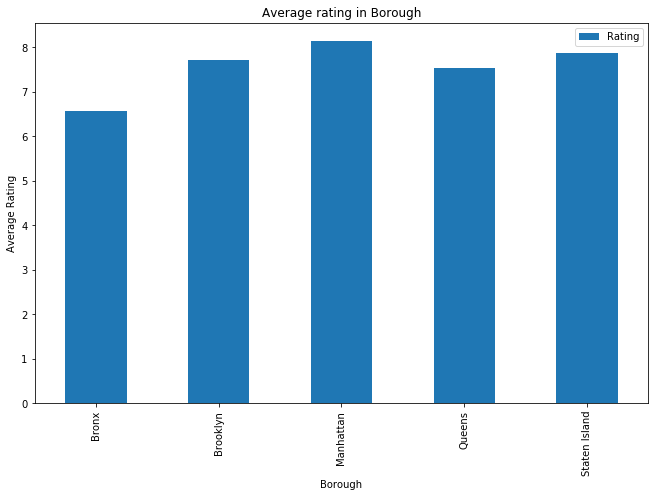

In [70]:
plt.figure(figsize=(11,7))
plt.title('Average rating in Borough')
plt.xlabel('Borough')
plt.ylabel('Average Rating')
avg_Borough_rating.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

### Thus we can see that Manhattan Borough is best if you like Indian cuisine

In [73]:
top_five_neigh=avg_neigh_rating.sort_values(['Rating'],ascending=False).head(5)
top_five_neigh                                                                    

,Neighborhood,Rating
0,Astoria,9.0
5,Blissville,9.0
25,Fort Greene,8.8
49,Prospect Heights,8.7
12,Civic Center,8.6


##### This shows the top five neighborhoods in NY with best Indian cuisine

In [74]:
neigh_data=pd.merge(new_york_data,top_five_neigh,on='Neighborhood')
neigh_data

,Borough,Neighborhood,Latitude,Longitude,Rating
0,Brooklyn,Prospect Heights,40.676822,-73.964859,8.7
1,Brooklyn,Fort Greene,40.688527,-73.972906,8.8
2,Queens,Astoria,40.768509,-73.915654,9.0
3,Manhattan,Civic Center,40.715229,-74.005415,8.6
4,Queens,Blissville,40.737251,-73.932442,9.0


### Let us visualize it on map

In [94]:
NY_map=folium.Map(location=get_location('New York'), zoom_start=10)


In [104]:
rest_feature = folium.map.FeatureGroup()

for lat, lng, in neigh_data[['Latitude','Longitude']].values:
    rest_feature.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [107]:
# add label
neigh_data['Label']=neigh_data['Borough']+','+neigh_data['Neighborhood']+', Rating: '+neigh_data['Rating'].map(str)
neigh_data

,Borough,Neighborhood,Latitude,Longitude,Rating,Label
0,Brooklyn,Prospect Heights,40.676822,-73.964859,8.7,"Brooklyn,Prospect Heights, Rating: 8.7"
1,Brooklyn,Fort Greene,40.688527,-73.972906,8.8,"Brooklyn,Fort Greene, Rating: 8.8"
2,Queens,Astoria,40.768509,-73.915654,9.0,"Queens,Astoria, Rating: 9.0"
3,Manhattan,Civic Center,40.715229,-74.005415,8.6,"Manhattan,Civic Center, Rating: 8.6"
4,Queens,Blissville,40.737251,-73.932442,9.0,"Queens,Blissville, Rating: 9.0"


In [117]:
# add popup to map
for lat, lng, label in neigh_data[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(NY_map)        
# add incidents to map
NY_map.add_child(rest_feature)   

## CONCLUSION

### Now form the above analysis we can give answers to all mentioned questions in the starting of the notebook

#### 1. Prospect Heights(Brooklyn), Fort Greene(Brooklyn), Astoria(Queens) are some of the best place with Indian cuisine.
#### 2. Manhattan has potential Indian restaurant market.
#### 3. 